# Class-conditional Experiment on EEG Dataset

This notebook provides a usage guide for generating multi-class time series using Diffusion-TS via [Classifier Guidance](https://arxiv.org/abs/2105.05233). The used [EEG data](https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State) and [pre-processing code](https://github.com/aliseyfi75/COSCI-GAN/blob/main/Code/EEG_data_preprocessing.ipynb) are forked from [COSCI-GAN](https://github.com/aliseyfi75/COSCI-GAN), so their contributions are appreciated here 😊. Also note that this part is not in the original paper, and we use the Transformer Encoder as the underlying model to build the classifier $p(y|x_t, t)$.

In [1]:
import numpy as np

train_data = np.load('D:\dev-project\Diffusion-TS-main\chb_exp\ori_data_1.npy')
# X_train = train_data['train_signals']
# X_train = np.transpose(X_train, (0, 2, 1))
# y_train = train_data['train_labels']
print(train_data.shape)
# print(y_train.shape)

(287, 256, 23)


In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../'))

import torch
import numpy as np

from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one, cond_fn

D:\dev-software\anaconda\envs\conda_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = '../Config/chb.yaml'
        self.gpu = 0
        self.save_dir = '../chb_exp'
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
classifier = instantiate_from_config(configs['classifier']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

(8282, 256, 23)
(8282,)
X_non_seizure-->(6487, 256, 23)
X_seizure-->(1795, 256, 23)
data-->(2120192, 23)
提取前的X_train_1=(1436, 256, 23)
提取后的data1=(718, 256, 23)


In [3]:
trainer.train()

loss: 15.338037:   0%|          | 16/12000 [00:54<11:19:09,  3.40s/it]


KeyboardInterrupt: 

In [ ]:
trainer.train_classfier(classifier)

In [5]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num

model_kwargs = {}
model_kwargs['classifier'] = trainer.classifier
model_kwargs['classifier_scale'] = 0.1

In [6]:
ori_data_1 = dataset.normalize(dataset.data_1)

model_kwargs['y'] = torch.ones((1001, )).long().to(device)

fake_data_1 = trainer.sample(num=len(ori_data_1), size_every=1001, shape=[seq_length, feature_dim], 
                             model_kwargs=model_kwargs, cond_fn=cond_fn)
if dataset.auto_norm:
    ori_data_1 = unnormalize_to_zero_to_one(ori_data_1)
    fake_data_1 = unnormalize_to_zero_to_one(fake_data_1)


sampling loop time step: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


In [7]:
np.save(os.path.join(args.save_dir, f'ddpm_fake_1_eeg.npy'), fake_data_1)
np.save(os.path.join(args.save_dir, f'ori_data_1.npy'), ori_data_1)

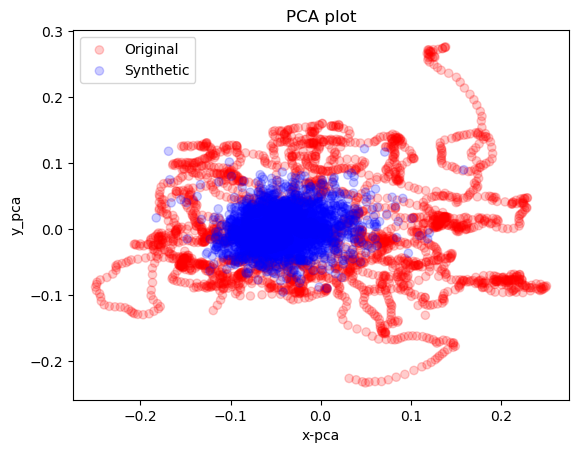

In [8]:
visualization(ori_data=ori_data_1, generated_data=fake_data_1, analysis='pca', compare=ori_data_1.shape[0])

In [ ]:
visualization(ori_data=ori_data_1, generated_data=fake_data_1, analysis='tsne', compare=ori_data_1.shape[0])

In [ ]:
visualization(ori_data=ori_data_1, generated_data=fake_data_1, analysis='kernel', compare=ori_data_1.shape[0])